# Gaussian Processes

Instead of placing a prior on the parameters, the idea is to define a prior on the approximation function itself.
The first part is dedicated to building a Gaussian Process 'by hand', the second part is doing the same, using the package GPy.

We consider the following function:

\begin{align*}
    y = f(x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)
\end{align*}

The Bayes theorem is, in this case:

\begin{align*}
p(f|X, y) = \frac{p(y|f, X)p(f|X)}{p(y|X)} 
\end{align*}

- $p(f|X)$ is the prior on the function, defined by a Gaussian Process (GP): $GP(m, k)$,
- $p(y|f, X)$ is the likelihood (noisy model), defined by a Gaussian $\mathcal{N}(f(X), \sigma_n^2 I)$,
- $p(y|X)$ is the marginal likelihood, is the integral $\int p(y|f, X)p(f|X) df$,
- $p(f|y, X)$ is the posterior, defined by: $GP(m_{post}, k_{post})$.

The GP can be seen as an infinite vector of Gaussians. But, since the dataset are always finite, the marginal remains finite (with $f=f_{train}$ and $f_*=f_{test}$):

\begin{align*}
p(f, f_*) = \int p(f,f_*, f_{other})d f_{other} = \mathcal{N} \left( 
\begin{bmatrix} 
\mu_f \\
\mu_* 
\end{bmatrix},
\begin{bmatrix} 
\Sigma_{ff} & \Sigma_{f*} \\
\Sigma_{*f} & \Sigma_{** }
\end{bmatrix}
\right)
\end{align*}

Since, the GP is just a 'vector' of Gaussians, we can rewrite the prior:

\begin{align*}
GP(m, k) = \mathcal{N}(m(X), K)
\end{align*}

Where $K$ is the covariance matrix between the different points of the dataset: $K=k(X,X)$.

Since, we can write similar expressions for the test set, the joint distribution can be expressed:

\begin{align*}
p(f, f_* | X, X_*) = \mathcal{N} \left( 
\begin{bmatrix} 
m(X) \\
m(X_*) 
\end{bmatrix},
\begin{bmatrix} 
K & k(X, X_*)\\
k(X_*, X) & k(X_*, X_*)
\end{bmatrix}
\right)
\end{align*}

Since we know the likelihood $\mathcal{N}(y|f(X), \sigma_n^2 I)$, we can rewrite the joint distribution:

\begin{align*}
p(y, f_* | X, X_*) = \mathcal{N} \left( 
\begin{bmatrix} 
m(X) \\
m(X_*) 
\end{bmatrix},
\begin{bmatrix} 
K + \sigma_n^2 I & k(X, X_*)\\
k(X_*, X) & k(X_*, X_*)
\end{bmatrix}
\right)
\end{align*}

The posterior distribution is then simply obtained by Gaussian conditioning:

\begin{align*}
p(f_* |X, y, X_*) = \mathcal{N}(m_{post}, k_{post})
\end{align*}

Where the mean function and the covariance function (kernel) are:

\begin{align*}
m_{post}(X_*) &= m(X_*) + k(X_*, X)(K+\sigma_n^2 I)^{-1} (y-m(X))\\
k_{post}(X_*, X_*) &= k(X_*, X_*)-k(X_*, X)(K+\sigma_n^2)^{-1}k(X, X_*)
\end{align*}

A commun kernel to choose is the Gaussian one:

\begin{align*}
k_{Gauss}(x_i, x_j) = \sigma_f^2 \exp \left(-\frac{(x_i-x_j)^T(x_i-x_j)}{l^2} \right)
\end{align*}

Where $\sigma_f^2$ is the amplitude parameter, and $l$ the legth-scale.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import GPy

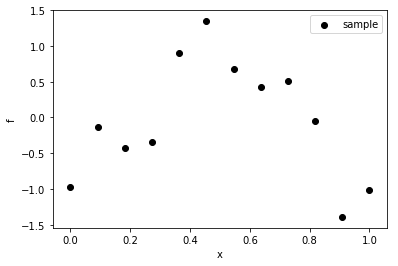

In [3]:
N = 12
sigma = 0.1 #std

def f(x):
    return -np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)

X = np.linspace(0, 1, N)[:,None]
Y = f(X) + np.random.normal(0, sigma, (N,1)) #std

plt.scatter(X, Y, label='sample', color='black')
plt.xlabel("x")
plt.ylabel("f")
plt.legend()

In [24]:
var = 1
l = 0.1

k = GPy.kern.RBF(1, variance=var, lengthscale=l, name="rbf") # kernel
Xnew = np.linspace(0, 1, 100)[:, None] # new test points
Kxx = k.K(X,X) + 1 * np.eye(N) # Covariance between training sample points (+ Gaussian noise)
Kxs = k.K(Xnew, X) # Covariance between training and test points
Kss = k.K(Xnew,Xnew) # Covariance between test points

# The mean of the GP fit
mean = Kxs @ np.linalg.inv(Kxx) @ Y
# The covariance matrix of the GP fit
Cov = Kss - Kxs @ np.linalg.inv(Kxx) @ Kxs.T

In [25]:
def plot_gp(X, m, C, training_points=None):
    plt.fill_between(X[:,0], m[:,0] - 1.96*np.sqrt(np.diag(C)), m[:,0] + 1.96*np.sqrt(np.diag(C)), color='lightgrey')
    plt.plot(X, m, color='black', label='GP fit')
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.scatter(X_, Y_, color='black', label='sample')
        plt.legend()

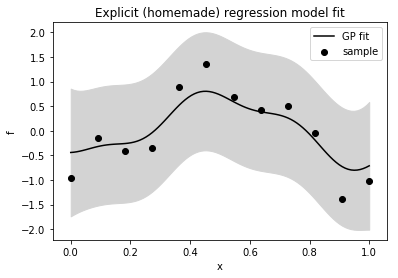

In [26]:
# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("Explicit (homemade) regression model fit");

In [27]:
m = GPy.models.GPRegression(X, Y, k)
m 

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,1.0,+ve,


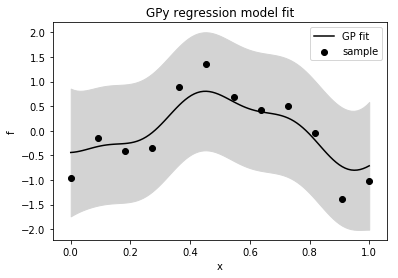

In [28]:
# Use GPy model to calculate the mean and covariance of the fit at Xnew
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

# Plot the GP fit mean and covariance
plot_gp(Xnew, mean, Cov, training_points=(X,Y))
plt.title("GPy regression model fit");

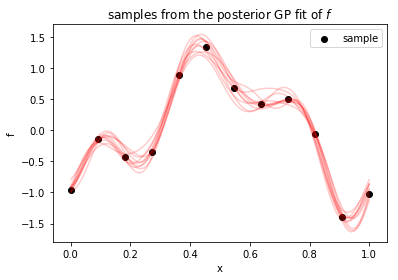

In [29]:
m.Gaussian_noise = 0.01
m.rbf.lengthscale = 0.1


mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

Z = np.random.multivariate_normal(mean[:,0], Cov, 10)

for z in Z:
    plt.plot(Xnew, z, "g-", alpha=0.2, color='red')
plt.scatter(X, Y, color='black', label='sample')
plt.xlabel("x")
plt.ylabel("f")
plt.title("samples from the posterior GP fit of $f$")
plt.legend()